In [27]:
import os
import torch.nn as nn
import torch
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
from tqdm.notebook import tqdm
import random
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
%matplotlib inline

In [28]:
dataset_folder = '/mnt/data/BraDD-S1TS_zenodo'
meta_csv_path = os.path.join(dataset_folder, 'meta.csv')

In [29]:
if os.path.exists(meta_csv_path):
    meta_df = pd.read_csv(meta_csv_path, index_col=0)
    print("Metadata loaded:")
    display(meta_df.head())
    print(f"Total samples: {meta_df.shape[0]}")
else:
    print("Meta CSV not found. Skipping metadata load.")

Metadata loaded:


,alert_idx,center_idx,date,sampling_type,state,file,close_set
0,0,0,2021-08-21,positive,PA,0000000_2021-08-21.pt,train
1,1,1,2020-09-20,positive,AM,0000001_2020-09-20.pt,train
2,2,2,2020-08-08,boundary,PA,0000002_2020-08-08.pt,validation
3,4,3,2020-07-24,positive,PA,0000003_2020-07-24.pt,train
4,5,4,2020-08-06,boundary,PA,0000004_2020-08-06.pt,train


Total samples: 25988


In [30]:
def read_sample(idx):
    file = meta_df['file'].iloc[idx]
    return torch.load(os.path.join(dataset_folder, 'Samples', file), weights_only=False)

In [31]:
change_indices = []
nochange_indices = []

for i, filename in enumerate(meta_df["file"]):
    if "_None" in filename:
        nochange_indices.append(i)
    else:
        change_indices.append(i)

print("Change samples:", len(change_indices))
print("No-change samples:", len(nochange_indices))

Change samples: 11006
No-change samples: 14982


In [32]:
# step 1. pick 500 random samples.
import random

random.seed(42)

TOTAL_SAMPLES = 500

official_indices = random.sample(range(len(meta_df)), TOTAL_SAMPLES)

print("Number of selected samples:", len(official_indices))
print("First 10 indices:", official_indices[:10])

Number of selected samples: 500
First 10 indices: [20952, 3648, 819, 24299, 9012, 8024, 7314, 4572, 24132, 3358]


In [33]:
change_count = 0
nochange_count = 0

for idx in official_indices:
    filename = meta_df['file'].iloc[idx]
    if "_None" in filename:
        nochange_count += 1
    else:
        change_count += 1

print("Change samples:", change_count)
print("No-change samples:", nochange_count)

Change samples: 226
No-change samples: 274


In [34]:
print(len(official_indices))

500


In [35]:
labels = []
for idx in official_indices:
    fname = meta_df['file'].iloc[idx]
    if "_None" in fname:
        labels.append(0)   # no change
    else:
        labels.append(1)   # deforestation

In [36]:
print("Change samples:", sum(labels))
print("No-change samples:", len(labels) - sum(labels))

Change samples: 226
No-change samples: 274


In [37]:
from sklearn.model_selection import train_test_split

trainval_idx, test_idx, trainval_y, test_y = train_test_split(
    official_indices,
    labels,
    test_size=0.20,
    random_state=42,
    stratify=labels
)


train_idx, val_idx, train_y, val_y = train_test_split(
    trainval_idx,
    trainval_y,
    test_size=0.125,      # 0.125 × 0.80 = 0.10 overall
    random_state=42,
    stratify=trainval_y
)

In [38]:
print("Train size:", len(train_idx))
print("Val size:", len(val_idx))
print("Test size:", len(test_idx))

def count_change(indices):
    c = sum(1 for x in indices if "_None" not in meta_df['file'].iloc[x])
    return c, len(indices) - c

print("Train (change, no-change):", count_change(train_idx))
print("Val   (change, no-change):", count_change(val_idx))
print("Test  (change, no-change):", count_change(test_idx))


Train size: 350
Val size: 50
Test size: 100
Train (change, no-change): (158, 192)
Val   (change, no-change): (23, 27)
Test  (change, no-change): (45, 55)


In [39]:
# import json

# splits = {
#     "train": train_idx,
#     "val": val_idx,
#     "test": test_idx
# }

# with open("official_data_splits.json", "w") as f:
#     json.dump(splits, f)

In [40]:
# Step 2. VALID TIME WINDOWS - function to identify valid timesteps

def get_valid_timesteps(sample):
    """
    Returns:
      img_valid (Tensor): (T_valid, 2, 48, 48)
      valid_idx (list): list of timestep indices kept
    """

    img = sample['image']            # original: (T, 2, 48, 48)
    dates = sample['image_dates']    # list of date strings

    pre_date  = sample['label_dates'][0]
    post_date = sample['label_dates'][1]

    valid_idx = [i for i, d in enumerate(dates) if pre_date <= d <= post_date]

    img_valid = img[valid_idx]

    return img_valid, valid_idx

In [41]:
idx = train_idx[1]
sample = read_sample(idx)

img_valid, valid_idx = get_valid_timesteps(sample)

print("Original T:", sample['image'].shape[0])
print("Valid T:", img_valid.shape[0])
# print("Valid indices:", valid_idx)
# print("Valid dates:", [sample['image_dates'][i] for i in valid_idx])
# print("Pre-date:", sample['label_dates'][0])
# print("Post-date:", sample['label_dates'][1])

Original T: 28
Valid T: 26


In [42]:
# Step 3 - normalization steps

MIN_VALUE = -50.0
MAX_VALUE = 0.0

def normalize_sample(sample):
    """
    Normalizes only the 'image' tensor but preserves all fields.
    """
    img = sample['image']    # (T, 2, 48, 48)

    # Normalize input images
    img_norm = torch.clamp((img - MIN_VALUE) / (MAX_VALUE - MIN_VALUE), 0.0, 1.0)

    # Return a full sample preserving metadata
    return {
        'image': img_norm,
        'label': sample['label'],              # keep label
        'image_dates': sample['image_dates'],  # KEEP
        'label_dates': sample['label_dates'],  # KEEP
    }

In [43]:
idx = train_idx[29]
sample_raw = read_sample(idx)
sample_norm = normalize_sample(sample_raw)

print("Before norm:", sample_raw['image'].min().item(), "-->", sample_raw['image'].max().item())
print("After norm:", sample_norm['image'].min().item(), "-->", sample_norm['image'].max().item())

Before norm: -36.2066764831543 --> 1.7754237651824951
After norm: 0.27586647868156433 --> 1.0


In [44]:
# Step 4 - Packaging all these data pre-processing steps into 1!

class BRADS1T_Dataset(Dataset):
    def __init__(self, indices):
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Load raw sample
        sample = read_sample(self.indices[idx])
        dataset_idx = self.indices[idx]

        # 1. Normalize
        sample = normalize_sample(sample)

        # 2. Extract valid time-window (pre → post)
        img_valid, valid_idx = get_valid_timesteps({
            "image": sample['image'],
            "image_dates": sample['image_dates'],
            "label_dates": sample['label_dates']
        })

        # 3. Label = post-change mask only
        lbl = sample['label'][1].float()     # (48, 48)

        return img_valid, lbl, dataset_idx

In [45]:
train_dataset = BRADS1T_Dataset(train_idx)
val_dataset   = BRADS1T_Dataset(val_idx)
test_dataset  = BRADS1T_Dataset(test_idx)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=1, shuffle=False)

In [46]:
img_valid, lbl, dataset_idx = next(iter(train_loader))
print(img_valid.shape)   # (1, T_valid, 2, 48, 48) or (T_valid, 2, 48, 48)
print(lbl.shape)         # (1, 48, 48) or (48, 48)
print(dataset_idx)

torch.Size([1, 26, 2, 48, 48])
torch.Size([1, 48, 48])
tensor([6940])


In [47]:
# e.g. --> sample 4681 has a differing number of valid timesteps than its original timesteps (same w/ sample 7223)
sample = read_sample(7223)
img_valid, valid_idx = get_valid_timesteps(sample)
print("Original T:", sample['image'].shape[0])
print("Valid T:", img_valid.shape[0])

Original T: 30
Valid T: 28


In [48]:
for i, (img_valid, lbl, dataset_idx) in zip(range(5), train_loader): 
    print(f"Sample {i}: T_valid = {img_valid.shape[1]}") # need to use index 1 because 0 index will return 1 because batch size = 1

Sample 0: T_valid = 45
Sample 1: T_valid = 28
Sample 2: T_valid = 31
Sample 3: T_valid = 31
Sample 4: T_valid = 29


# Models

## DataVis

In [86]:
import torch
import matplotlib.pyplot as plt

def visualize_prediction(img_seq, label, model, device='cpu', threshold=0.5):
    """
    img_seq: (B=1, T, 2, 48, 48)
    label:   (B=1, 1, 48, 48)
    model:   your trained model
    """

    model.eval()
    with torch.no_grad():
        img_seq = img_seq.to(device)
        label = label.to(device)

        logits = model(img_seq)
        probs  = torch.sigmoid(logits)
        pred   = (probs >= threshold).float()

    # detach and convert to numpy for plotting
    first = img_seq[0, 0].cpu().numpy()          # (2,48,48)
    last  = img_seq[0, -1].cpu().numpy()         # (2,48,48)
    gt    = label[0,0].cpu().numpy()             # (48,48)
    pr    = pred[0,0].cpu().numpy()              # (48,48)

    # Plot
    plt.figure(figsize=(10,3))

    # First frame — show channel 0 for clarity
    plt.subplot(1,4,1)
    plt.imshow(first[0], cmap='gray')
    plt.title("First Frame (ch0)")
    plt.axis('off')

    # Last frame
    plt.subplot(1,4,2)
    plt.imshow(last[0], cmap='gray')
    plt.title("Last Frame (ch0)")
    plt.axis('off')

    # Ground truth
    plt.subplot(1,4,3)
    plt.imshow(gt, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Prediction
    plt.subplot(1,4,4)
    plt.imshow(pr, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


## Metrics

In [49]:
import torch
import torch.nn.functional as F

def batch_iou_from_logits(logits, labels, threshold=0.5, eps=1e-6):
    """
    logits: (B, 1, H, W) raw model outputs
    labels: (B, 1, H, W) with values in {0,1} or [0,1]
    """
    # convert logits to probabilities
    probs = torch.sigmoid(logits)

    # threshold to get binary predictions
    preds = (probs >= threshold).float()

    # ensure labels are binary 0/1
    labels_bin = (labels > 0.5).float()

    # flatten per sample
    preds = preds.view(preds.size(0), -1)
    labels_bin = labels_bin.view(labels_bin.size(0), -1)

    # intersection and union per sample
    intersection = (preds * labels_bin).sum(dim=1)
    union = preds.sum(dim=1) + labels_bin.sum(dim=1) - intersection

    iou = (intersection + eps) / (union + eps)  # avoid div by zero
    return iou.mean().item() 

In [74]:
def batch_f1_from_logits(logits, labels, threshold=0.5, eps=1e-6):
    """
    logits: (B, 1, H, W) raw outputs
    labels: (B, 1, H, W) with values in {0,1} or [0,1]
    Returns: scalar F1 averaged over batch (per-pixel)
    """
    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).float()
    labels_bin = (labels > 0.5).float()

    # flatten per sample
    preds = preds.view(preds.size(0), -1)
    labels_bin = labels_bin.view(labels_bin.size(0), -1)

    # per-sample counts
    tp = (preds * labels_bin).sum(dim=1)
    fp = (preds * (1 - labels_bin)).sum(dim=1)
    fn = ((1 - preds) * labels_bin).sum(dim=1)

    f1 = (2 * tp + eps) / (2 * tp + fp + fn + eps)  # (B,)
    return f1.mean().item()

## Original CNN

In [50]:
import torch
import torch.nn as nn

IMG_HEIGHT = 48
IMG_WIDTH = 48
IN_CHANNELS = 2
OUT_CHANNELS = 16

# select device if available
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

class CNN_Deforest(nn.Module):
    def __init__(self):
        super().__init__()
        
        # layer 1 (2, 48, 48) -> (2, 48, 48)
        self.cnn_layer = nn.Sequential(
            nn.Conv2d(IN_CHANNELS, OUT_CHANNELS, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(OUT_CHANNELS, OUT_CHANNELS, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(OUT_CHANNELS, OUT_CHANNELS, kernel_size=3, stride=1, padding='same'),
            nn.ReLU()
        )
        

    def forward(self, x):
        return self.cnn_layer(x)

In [51]:
cnn_model = CNN_Deforest()
for batch in train_loader:
    img, label, _ = batch
    no_batch_one_time_series = img.squeeze()
    output = cnn_model(no_batch_one_time_series)
    print(output.shape)
    print(label.shape)
    
    break

torch.Size([30, 16, 48, 48])
torch.Size([1, 48, 48])


In [52]:
gbl_avg_pool = nn.AdaptiveAvgPool2d((1,1))
layer = gbl_avg_pool(output).squeeze().unsqueeze(0)
layer.shape

torch.Size([1, 30, 16])

In [53]:
hidden_dim = 32
img_size = 48 * 48

In [54]:
lstm = nn.LSTM(input_size=16, hidden_size=32, num_layers=1, batch_first=True)
output, (h_T, c_T) = lstm(layer)
h_T[-1]

tensor([[-0.0616,  0.0393, -0.0594,  0.0442,  0.0365, -0.0215, -0.1024, -0.0451,
          0.0651, -0.0489,  0.1474, -0.0164,  0.0313,  0.0121, -0.1123, -0.0195,
          0.0967,  0.0243, -0.0486,  0.0711,  0.1095,  0.0761, -0.0018,  0.0279,
         -0.1656, -0.0530,  0.0826, -0.0273,  0.0418, -0.0399,  0.1080,  0.1478]],
       grad_fn=<SelectBackward0>)

In [55]:
linear_output = nn.Linear(hidden_dim, img_size)
final = linear_output(h_T)
final = final.reshape((1, 48, 48))
final.shape

torch.Size([1, 48, 48])

In [56]:
criterion = nn.BCEWithLogitsLoss()
loss = criterion(final, label)

## Original CNN + LSTM

In [87]:
import torch
import torch.nn as nn

# default data parameters
IMG_HEIGHT = 48
IMG_WIDTH = 48
IN_CHANNELS = 2

# cnn output
OUT_CHANNELS = 16

# lstm hidden size
HIDDEN_DIM = 32


class CNN_Deforest(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layer = nn.Sequential(
            nn.Conv2d(IN_CHANNELS, OUT_CHANNELS, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(OUT_CHANNELS, OUT_CHANNELS, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(OUT_CHANNELS, OUT_CHANNELS, kernel_size=3, stride=1, padding='same'),
            nn.ReLU()
        )

    def forward(self, x):
        # in this we kind of ignore batches of time series
        # we pass in one time series of length T at a time
        # input size: (T, 2, 48, 48)
        # output size: (T, 16, 48, 48)
        return self.cnn_layer(x)


class DeforestSequenceModel(nn.Module):
    def __init__(self, hidden_dim=HIDDEN_DIM):
        super().__init__()
        # cnn layer
        # input size: (T, 2, 48, 48)
        # output size: (T, 16, 48, 48)
        self.cnn = CNN_Deforest()

        # global avg pooling
        # input size: (T, 16, 48, 48)
        # output size: (T, 16)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # lstm layer
        # input size: (1, T, 16)
        # output size: (1, 32)
        self.lstm = nn.LSTM(
            input_size=OUT_CHANNELS,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True
        )

        # decoder
        # input size: (32, )
        # output size: (48, 48)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 1000),
            nn.ReLU(),
            nn.Linear(1000, IMG_HEIGHT * IMG_WIDTH)
        )

    def forward(self, x):
        """
        x: (B, T, 2, 48, 48)
        For now we assume B = 1 (one area at a time).
        """
        B, T, C, H, W = x.shape
        assert B == 1, "Current implementation assumes batch size 1 (one area per forward)."

        # 1. Drop batch dim, treat T as batch for CNN: (T, 2, 48, 48)
        x_seq = x[0]  # (T, 2, 48, 48)

        # 2. CNN per frame: (T, 2, 48, 48) -> (T, 16, 48, 48)
        feat_maps = self.cnn(x_seq)  # (T, 16, 48, 48)

        # 3. Global average pooling per frame: (T, 16, 48, 48) -> (T, 16, 1, 1) -> (T, 16)
        pooled = self.pool(feat_maps)                  # (T, 16, 1, 1)
        pooled = pooled.squeeze(-1).squeeze(-1)        # (T, 16)

        # 4. Add batch dim for LSTM: (1, T, 16)
        seq_for_lstm = pooled.unsqueeze(0)             # (1, T, 16)

        # 5. LSTM over time: (1, T, 16) -> final hidden (1, hidden_dim)
        lstm_out, (h_T, c_T) = self.lstm(seq_for_lstm)
        last_h = h_T[-1]                               # (1, hidden_dim)

        # 6. Decode to flat logits: (1, hidden_dim) -> (1, 2304)
        flat_logits = self.decoder(last_h)             # (1, 48*48)

        # 7. Reshape to mask: (1, 1, 48, 48)
        mask_logits = flat_logits.view(1, 1, IMG_HEIGHT, IMG_WIDTH)

        return mask_logits


### Broken Training

In [98]:
lr=0.01
model = DeforestSequenceModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)


In [99]:
num_epochs = 10   # change as needed
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for img, label, _ in train_loader:
        
        # Ensure labels have shape (1, 1, 48, 48)
        if label.ndim == 3:  
            label = label.unsqueeze(1)    # (1, 48, 48) -> (1, 1, 48, 48)

        # 1. Forward pass
        logits = model(img)   # (1, 1, 48, 48)

        # 2. Compute loss
        loss = criterion(logits, label.float())

        # 3. Backprop + update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f}")

Epoch 1/10 | Loss: 0.4807
Epoch 2/10 | Loss: 0.4710
Epoch 3/10 | Loss: 0.4634
Epoch 4/10 | Loss: 0.4645
Epoch 5/10 | Loss: 0.4592
Epoch 6/10 | Loss: 0.4659
Epoch 7/10 | Loss: 0.4674
Epoch 8/10 | Loss: 0.4650
Epoch 9/10 | Loss: 0.4666
Epoch 10/10 | Loss: 0.4626


In [100]:
# is model wired correctly
# ---- Grab ONE batch from the train_loader ----
img_one, label_one, _ = next(iter(train_loader))

# Make sure label is (B, 1, 48, 48)
if label_one.ndim == 3:        # (B, 48, 48)
    label_one = label_one.unsqueeze(1)   # -> (B, 1, 48, 48)

# Re-init a fresh model, criterion, optimizer for this toy test
model = DeforestSequenceModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Overfitting a single batch...")
for step in range(200):
    model.train()

    logits = model(img_one)            # (B, 1, 48, 48)
    loss = criterion(logits, label_one.float())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 20 == 0:
        print(f"Step {step}: loss = {loss.item():.4f}")


Overfitting a single batch...
Step 0: loss = 0.6962
Step 20: loss = 0.5996
Step 40: loss = 0.2829
Step 60: loss = 0.1275
Step 80: loss = 0.0744
Step 100: loss = 0.0516
Step 120: loss = 0.0391
Step 140: loss = 0.0312
Step 160: loss = 0.0257
Step 180: loss = 0.0217


In [101]:
# most pos neg anyways
model.eval()

with torch.no_grad():
    img_batch, label_batch, _ = next(iter(train_loader))

    if label_batch.ndim == 3:          # (B, 48, 48)
        label_batch = label_batch.unsqueeze(1).float()   # -> (B, 1, 48, 48)

    logits = model(img_batch)          # (B, 1, 48, 48)
    probs = torch.sigmoid(logits)      # (B, 1, 48, 48)

    print("Pred mean prob:", probs.mean().item())
    print("Label mean:", label_batch.mean().item())

Pred mean prob: 0.0189481470733881
Label mean: 0.2057291716337204


### Repaired Training

In [88]:
lr=1e-2
model = DeforestSequenceModel(256)
pos_weight = torch.tensor([5.0])   # you can tweak this later
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr)

In [89]:
num_epochs = 10   # change as needed
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    running_f1  = 0.0
    n_batches = 0
    
    for img, label, _ in train_loader:
        
        # Ensure labels have shape (1, 1, 48, 48)
        if label.ndim == 3:  
            label = label.unsqueeze(1)    # (1, 48, 48) -> (1, 1, 48, 48)

        # 1. Forward pass
        logits = model(img)   # (1, 1, 48, 48)

        # 2. Compute loss
        loss = criterion(logits, label.float())

        # 3. Backprop + update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics (no grad)
        with torch.no_grad():
            batch_iou = batch_iou_from_logits(logits, label.float())
            batch_f1  = batch_f1_from_logits(logits, label.float())

        running_loss += loss.item()
        running_iou  += batch_iou
        running_f1   += batch_f1
        n_batches    += 1

    avg_loss = running_loss / n_batches
    avg_iou  = running_iou / n_batches
    avg_f1   = running_f1  / n_batches

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Loss: {avg_loss:.4f} | IoU: {avg_iou:.4f} | F1: {avg_f1:.4f}"
    )

Epoch 1/10 | Loss: 1.4744 | IoU: 0.1610 | F1: 0.2268


KeyboardInterrupt: 

In [144]:
it = iter(test_loader)

In [156]:
# most pos neg anyways
model.eval()

with torch.no_grad():
    img_batch, label_batch, _ = next(it)

    if label_batch.ndim == 3:          # (B, 48, 48)
        label_batch = label_batch.unsqueeze(1).float()   # -> (B, 1, 48, 48)

    logits = model(img_batch)          # (B, 1, 48, 48)
    probs = torch.sigmoid(logits)      # (B, 1, 48, 48)

    print("Pred mean prob:", probs.mean().item())
    print("Label mean:", label_batch.mean().item())

Pred mean prob: 0.48427343368530273
Label mean: 0.0


In [159]:
model.eval()
with torch.no_grad():
    img_batch, label_batch, _ = next(it)
    if label_batch.ndim == 3:
        label_batch = label_batch.unsqueeze(1).float()  # (B,1,48,48)

    logits = model(img_batch)          # (B,1,48,48)
    probs = torch.sigmoid(logits)

    print("  Pred mean prob:", probs.mean().item())
    print("  Pred std prob: ", probs.std().item())
    print("  Label mean:    ", label_batch.mean().item())

    # print a small slice of the map for sanity
    print("  Sample probs[0,0,0,:5]:", probs[0, 0, 0, :5])
    print("  Sample label[0,0,0,:5]:", label_batch[0, 0, 0, :5])


  Pred mean prob: 0.4842774569988251
  Pred std prob:  0.10932289063930511
  Label mean:     0.2612847089767456
  Sample probs[0,0,0,:5]: tensor([0.3138, 0.3213, 0.3303, 0.3266, 0.3455])
  Sample label[0,0,0,:5]: tensor([0., 0., 0., 0., 0.])


## Simple CNN

In [90]:
import torch
import torch.nn as nn

IMG_HEIGHT = 48
IMG_WIDTH = 48
IN_CHANNELS = 2      # original
OUT_CHANNELS = 32    # feature channels inside the CNN

class FirstLast4ChanSeg(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder-ish stack that preserves H,W
        self.features = nn.Sequential(
            nn.Conv2d(4, OUT_CHANNELS, kernel_size=3, padding=1),  # (B,4,48,48)->(B,32,48,48)
            nn.ReLU(),
            nn.Conv2d(OUT_CHANNELS, OUT_CHANNELS, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(OUT_CHANNELS, OUT_CHANNELS, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(OUT_CHANNELS, OUT_CHANNELS, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(OUT_CHANNELS, OUT_CHANNELS, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # 1×1 conv head: per-pixel classifier
        self.head = nn.Conv2d(OUT_CHANNELS, 1, kernel_size=1)      # (B,32,48,48)->(B,1,48,48)

    def forward(self, x):
        """
        x: (B, T, 2, 48, 48)
        assume label is mask for LAST frame.
        """
        B, T, C, H, W = x.shape
        assert C == 2
        assert T >= 2

        first = x[:, 0]      # (B, 2, 48, 48)
        last  = x[:, -1]     # (B, 2, 48, 48)

        # stack to 4 channels: [c1_first, c2_first, c1_last, c2_last]
        four_chan = torch.cat([first, last], dim=1)   # (B, 4, 48, 48)

        feat = self.features(four_chan)               # (B, 32, 48, 48)
        logits = self.head(feat)                      # (B, 1, 48, 48)

        return logits   # raw logits for BCEWithLogitsLoss

### Training

In [91]:
lr=1e-3
model = FirstLast4ChanSeg()
pos_weight = torch.tensor([5.0])   # you can tweak this later
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr)

In [92]:
num_epochs = 10   # change as needed
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    running_f1 = 0.0
    n_batches = 0
    
    
    for img, label, _ in train_loader:
        
        # Ensure labels have shape (1, 1, 48, 48)
        if label.ndim == 3:  
            label = label.unsqueeze(1)    # (1, 48, 48) -> (1, 1, 48, 48)

        # 1. Forward pass
        logits = model(img)   # (1, 1, 48, 48)

        # 2. Compute loss
        loss = criterion(logits, label.float())

        # 3. Backprop + update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics (no grad)
        with torch.no_grad():
            batch_iou = batch_iou_from_logits(logits, label.float())
            batch_f1  = batch_f1_from_logits(logits, label.float())

        running_loss += loss.item()
        running_iou  += batch_iou
        running_f1   += batch_f1
        n_batches    += 1

    avg_loss = running_loss / n_batches
    avg_iou  = running_iou / n_batches
    avg_f1   = running_f1  / n_batches

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Loss: {avg_loss:.4f} | IoU: {avg_iou:.4f} | F1: {avg_f1:.4f}"
    )

Epoch 1/10 | Loss: 1.3220 | IoU: 0.1736 | F1: 0.2360
Epoch 2/10 | Loss: 1.1826 | IoU: 0.1746 | F1: 0.2342
Epoch 3/10 | Loss: 1.1722 | IoU: 0.1927 | F1: 0.2603
Epoch 4/10 | Loss: 1.1590 | IoU: 0.2028 | F1: 0.2618
Epoch 5/10 | Loss: 1.1562 | IoU: 0.1778 | F1: 0.2462
Epoch 6/10 | Loss: 1.1468 | IoU: 0.1748 | F1: 0.2460
Epoch 7/10 | Loss: 1.1652 | IoU: 0.1731 | F1: 0.2412
Epoch 8/10 | Loss: 1.1552 | IoU: 0.1724 | F1: 0.2427
Epoch 9/10 | Loss: 1.1466 | IoU: 0.1740 | F1: 0.2449
Epoch 10/10 | Loss: 1.1461 | IoU: 0.1753 | F1: 0.2467


In [94]:
it=iter(train_loader)

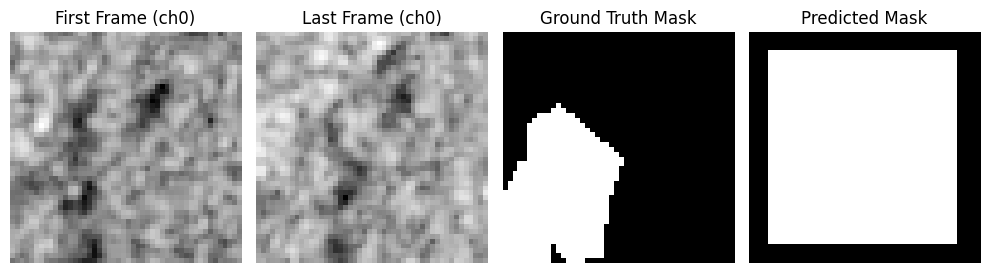

In [98]:
# get one batch
img, label, _ = next(it)

# ensure correct shape
if label.ndim == 3:
    label = label.unsqueeze(1)

visualize_prediction(img, label, model, device)

In [99]:
import torch
import matplotlib.pyplot as plt

def compute_mean_label_and_pred(model, dataloader, device='cpu', threshold=0.5, max_batches=None):
    model.eval()
    sum_label = None
    sum_pred  = None
    count = 0

    with torch.no_grad():
        for b, (img, label, _) in enumerate(dataloader):
            if max_batches is not None and b >= max_batches:
                break

            if label.ndim == 3:
                label = label.unsqueeze(1)      # (B,1,H,W)

            img = img.to(device)
            label = label.float().to(device)

            logits = model(img)
            probs  = torch.sigmoid(logits)
            pred   = (probs >= threshold).float()

            if sum_label is None:
                sum_label = label.sum(dim=0)    # (1,H,W)
                sum_pred  = pred.sum(dim=0)     # (1,H,W)
            else:
                sum_label += label.sum(dim=0)
                sum_pred  += pred.sum(dim=0)

            count += label.size(0)

    mean_label = (sum_label / count).squeeze(0).cpu().numpy()  # (H,W)
    mean_pred  = (sum_pred  / count).squeeze(0).cpu().numpy()  # (H,W)
    return mean_label, mean_pred


def plot_mean_maps(mean_label, mean_pred):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(mean_label, cmap='hot')
    plt.title("Mean Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(mean_pred, cmap='hot')
    plt.title("Mean Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


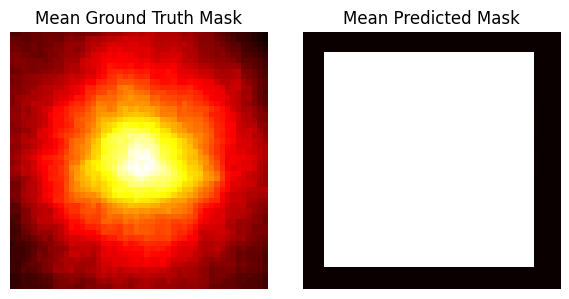

In [100]:
mean_label, mean_pred = compute_mean_label_and_pred(model, train_loader, device)
plot_mean_maps(mean_label, mean_pred)


## ResNet

In [82]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet4ChanBackbone(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # 1. Load pretrained ResNet18
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)

        # 2. Adapt first conv from 3 -> 4 channels
        old_conv = resnet.conv1
        new_conv = nn.Conv2d(
            in_channels=4,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=old_conv.bias is not None,
        )

        with torch.no_grad():
            # copy RGB weights
            new_conv.weight[:, :3] = old_conv.weight
            # initialize 4th channel as mean of R,G,B filters
            new_conv.weight[:, 3:] = old_conv.weight.mean(dim=1, keepdim=True)

            if old_conv.bias is not None:
                new_conv.bias.copy_(old_conv.bias)

        resnet.conv1 = new_conv

        # 3. Use everything up to layer4 as encoder
        self.encoder = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4,
        )

        self.out_channels = 512  # resnet18 last feature dim

    def forward(self, x):
        return self.encoder(x)   # (B, 512, Hf, Wf)


In [83]:
class ResNet4ChanSegModel(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.backbone = ResNet4ChanBackbone(pretrained=pretrained)

        # simple decoder: conv + upsample → 48x48 → 1-channel mask
        self.decoder = nn.Sequential(
            nn.Conv2d(self.backbone.out_channels, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(size=(48, 48), mode='bilinear', align_corners=False),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x_seq):
        """
        x_seq: (B, T, 2, 48, 48)
        assume label is mask for LAST frame.
        """
        B, T, C, H, W = x_seq.shape
        assert C == 2 and T >= 2

        first = x_seq[:, 0]   # (B, 2, 48, 48)
        last  = x_seq[:, -1]  # (B, 2, 48, 48)

        # stack into 4-channel pseudo-image
        x_4 = torch.cat([first, last], dim=1)  # (B, 4, 48, 48)

        feats = self.backbone(x_4)             # (B, 512, Hf, Wf tiny)
        logits = self.decoder(feats)           # (B, 1, 48, 48)

        return logits  # raw logits


In [84]:
model = ResNet4ChanSegModel(pretrained=True)
for p in model.backbone.parameters():
    p.requires_grad = False  # freeze encoder

# later you can unfreeze some layers if you want more adaptation


In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet4ChanSegModel(pretrained=True).to(device)

criterion = nn.BCEWithLogitsLoss()  # maybe start *without* pos_weight
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-2)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    running_f1 = 0.0
    n_batches = 0

    for img, label, _ in train_loader:
        img = img.to(device)  # (B, T, 2, 48, 48)

        if label.ndim == 3:
            label = label.unsqueeze(1)  # -> (B, 1, 48, 48)
        label = label.float().to(device)

        logits = model(img)
        loss = criterion(logits, label)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        # Metrics (no grad)
        with torch.no_grad():
            batch_iou = batch_iou_from_logits(logits, label.float())
            batch_f1  = batch_f1_from_logits(logits, label.float())

        running_loss += loss.item()
        running_iou  += batch_iou
        running_f1   += batch_f1
        n_batches    += 1

    avg_loss = running_loss / n_batches
    avg_iou  = running_iou / n_batches
    avg_f1   = running_f1  / n_batches

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Loss: {avg_loss:.4f} | IoU: {avg_iou:.4f} | F1: {avg_f1:.4f}"
    )

Epoch 1/10 | Loss: 1.0750 | IoU: 0.5416 | F1: 0.5424
Epoch 1/10 | Loss: 1.0750 | IoU: 0.5416
Epoch 2/10 | Loss: 0.4594 | IoU: 0.5486 | F1: 0.5486
Epoch 2/10 | Loss: 0.4594 | IoU: 0.5486
Epoch 3/10 | Loss: 0.4570 | IoU: 0.5486 | F1: 0.5486
Epoch 3/10 | Loss: 0.4570 | IoU: 0.5486
Epoch 4/10 | Loss: 0.4563 | IoU: 0.5486 | F1: 0.5486
Epoch 4/10 | Loss: 0.4563 | IoU: 0.5486
Epoch 5/10 | Loss: 0.4544 | IoU: 0.5486 | F1: 0.5486
Epoch 5/10 | Loss: 0.4544 | IoU: 0.5486


KeyboardInterrupt: 

# Rest of Code

In [133]:
class LSTM_deforest(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm_layer = nn.Sequential(
            
        )

    def forward(self, x):
        return self.lstm_layer(x)
        

In [119]:
z = z.reshape(-1, 16, 48 * 48)

z = z.swapaxes(0, 2)
z = z.swapaxes(1, 2) 

z.shape

torch.Size([2304, 26, 16])

In [114]:
################## BASELINE CNN MODEL --> Pixel Wise!!! ###########################################

























In [25]:
import torch
import torch.nn as nn

class CNNFeatureExtractor(nn.Module):
    def __init__(self, out_channels=16):
        """
        out_channels = number of feature channels per pixel.
        Keep this small (8, 16, or 32) so LSTM does not explode.
        """
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(16, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        """
        x: (B, 2, 48, 48)
        Returns:
        feature map: (B, out_channels, 48, 48)
        """
        return self.conv(x)

In [25]:
cnn = CNNFeatureExtractor(out_channels=16)

dummy = torch.randn(1, 2, 48, 48)    # one timestep
features = cnn(dummy)

print("CNN Output shape:", features.shape)

CNN Output shape: torch.Size([1, 16, 48, 48])


In [26]:
cnn = CNNFeatureExtractor(out_channels=16)
cnn.eval()

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)


img_valid, lbl, idx = next(iter(train_loader))

print("img_valid shape:", img_valid.shape)

img_valid shape: torch.Size([1, 31, 2, 48, 48])


In [27]:
B, T, C, H, W = img_valid.shape

cnn_features = []

for t in range(T):
    x_t = img_valid[:, t]                 # shape (1,2,48,48)
    feat_t = cnn(x_t)                     # shape (1,16,48,48)
    cnn_features.append(feat_t)

print("Number of timesteps processed:", len(cnn_features))
print("Shape of CNN feature map:", cnn_features[0].shape)

Number of timesteps processed: 31
Shape of CNN feature map: torch.Size([1, 16, 48, 48])


In [28]:
t = 0
x = img_valid[0, t]             # (2,48,48)
feat = cnn_features[t][0]       # (16,48,48)

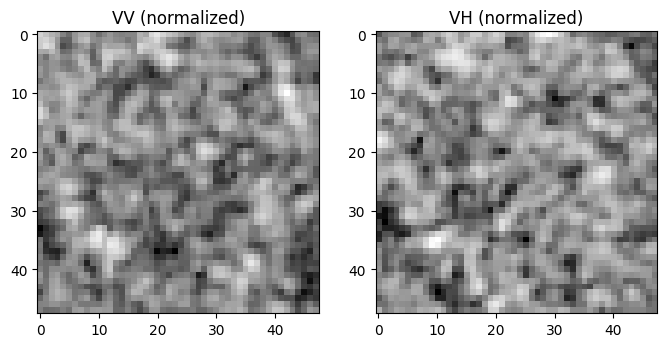

In [29]:
#plotting the INPUT

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(x[0], cmap='gray')
plt.title("VV (normalized)")

plt.subplot(1,2,2)
plt.imshow(x[1], cmap='gray')
plt.title("VH (normalized)")

plt.show()


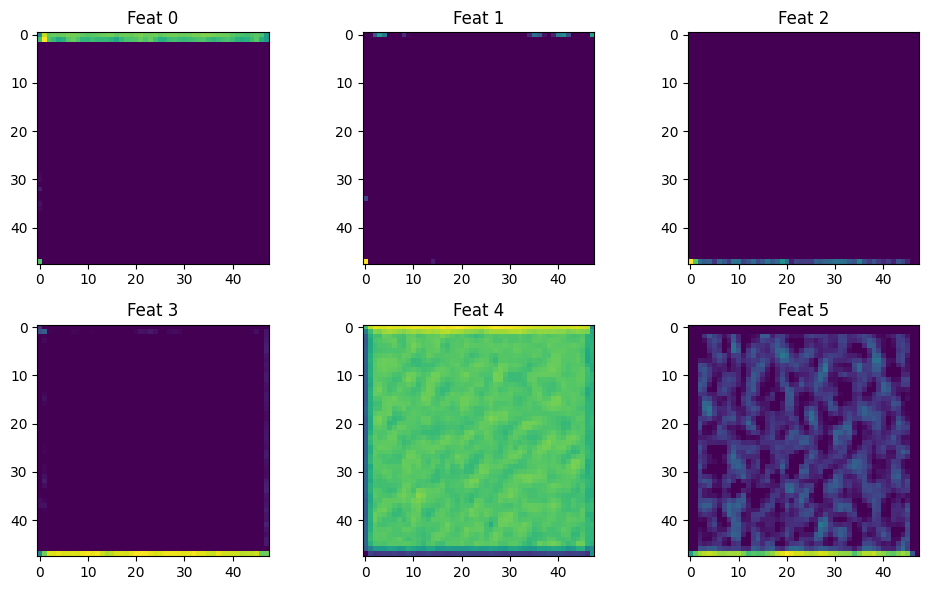

In [30]:
# plotting first few feature maps!
plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(feat[i].detach().numpy(), cmap='viridis')
    plt.title(f"Feat {i}")
plt.tight_layout()
plt.show()

In [31]:
print("Feature min:", feat.min().item())
print("Feature max:", feat.max().item())


Feature min: 0.0
Feature max: 0.3888138234615326


In [32]:
feat_flat = feat.permute(1,2,0).reshape(-1, feat.shape[0])
print("Flattened feature shape:", feat_flat.shape)

Flattened feature shape: torch.Size([2304, 16])


In [33]:
img_valid, lbl, idx = next(iter(train_loader))
print(img_valid.shape)

torch.Size([1, 54, 2, 48, 48])


In [34]:
B, T, C_in, H, W = img_valid.shape
cnn = CNNFeatureExtractor(out_channels=16)
cnn.eval()

feature_maps = []

for t in range(T):
    x_t = img_valid[:, t]            # (1,2,48,48)
    feat_t = cnn(x_t)                # (1,16,48,48)
    feature_maps.append(feat_t[0])   # (16,48,48)

In [35]:
# extracting a per-pixel vector across time!
y, x = 24, 24
pixel_sequence = []

for t in range(T):
    vec = feature_maps[t][:, y, x]   # shape (C,)
    pixel_sequence.append(vec)

pixel_sequence = torch.stack(pixel_sequence)  # shape (T, C)
print(pixel_sequence.shape)

torch.Size([54, 16])


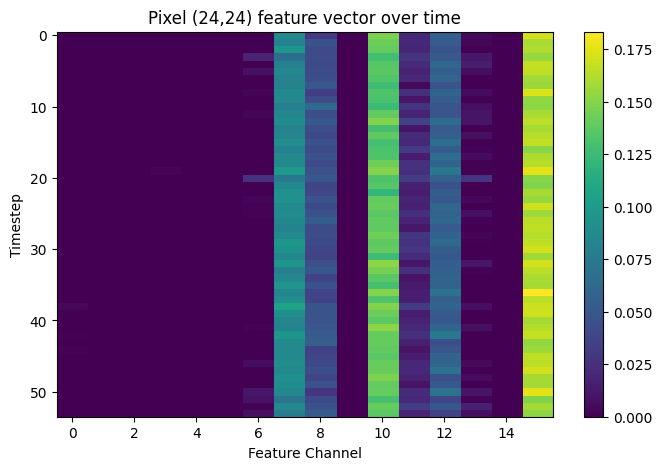

In [36]:
plt.figure(figsize=(8,5))
plt.imshow(pixel_sequence.detach().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.xlabel("Feature Channel")
plt.ylabel("Timestep")
plt.title(f"Pixel ({y},{x}) feature vector over time")
plt.show()

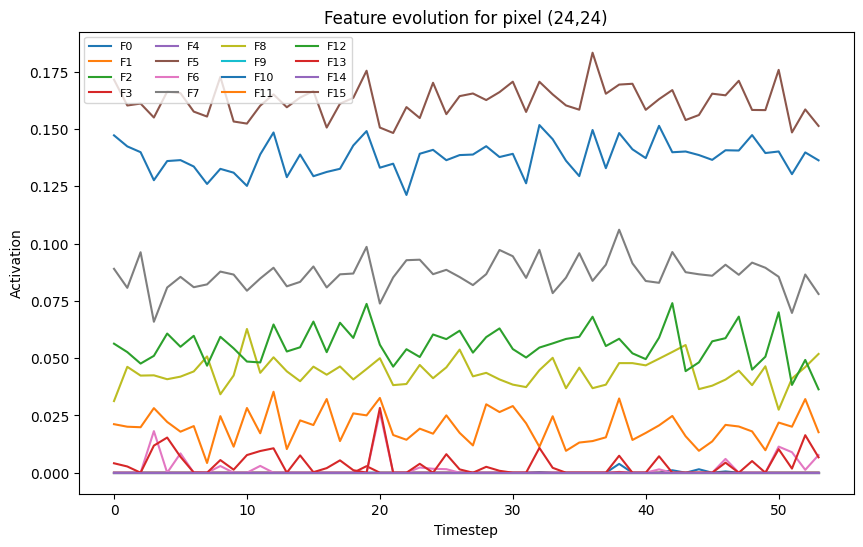

In [37]:
plt.figure(figsize=(10,6))
for c in range(pixel_sequence.shape[1]):
    plt.plot(pixel_sequence[:, c].detach().numpy(), label=f"F{c}")

plt.xlabel("Timestep")
plt.ylabel("Activation")
plt.title(f"Feature evolution for pixel ({y},{x})")
plt.legend(ncol=4, fontsize=8)
plt.show()

In [38]:
# A) Visualize multiple random pixels to compare changed vs unchanged

In [39]:
# Find first "change" sample
for i in range(len(train_dataset.indices)):
    idx = train_dataset.indices[i]
    sample = read_sample(idx)
    if sample['label'][1].sum() > 0:
        change_idx = idx
        break

print("Using sample:", change_idx)

Using sample: 9810


In [40]:
sample = read_sample(change_idx)
sample_norm = normalize_sample(sample)

# Extract the valid time window
img_valid, _ = get_valid_timesteps(sample_norm)
print("Valid timesteps:", img_valid.shape[0])

Valid timesteps: 26


In [41]:
cnn = CNNFeatureExtractor(out_channels=16)
cnn.eval()

T = img_valid.shape[0]
feature_maps = []

for t in range(T):
    x_t = img_valid[t].unsqueeze(0)   # (1,2,48,48)
    fm = cnn(x_t)[0]                  # (16,48,48)
    feature_maps.append(fm)

In [42]:
lbl = sample['label'][1]   # (48,48)
changed_pixels = torch.nonzero(lbl == 1)
unchanged_pixels = torch.nonzero(lbl == 0)

In [43]:
import random
random.seed(0)

# pick 3 changed pixels and 3 unchanged pixels
changed_sel = random.sample(changed_pixels.tolist(), 3)
unchanged_sel = random.sample(unchanged_pixels.tolist(), 3)

print("Changed pixels:", changed_sel)
print("Unchanged pixels:", unchanged_sel)


Changed pixels: [[30, 44], [17, 21], [25, 24]]
Unchanged pixels: [[26, 13], [1, 34], [12, 14]]


In [44]:
def extract_pixel_seq(feature_maps, y, x):
    seq = []
    for fm in feature_maps:          # each fm is (16,48,48)
        seq.append(fm[:, y, x])      # → (16)
    return torch.stack(seq)          # → (T,16)

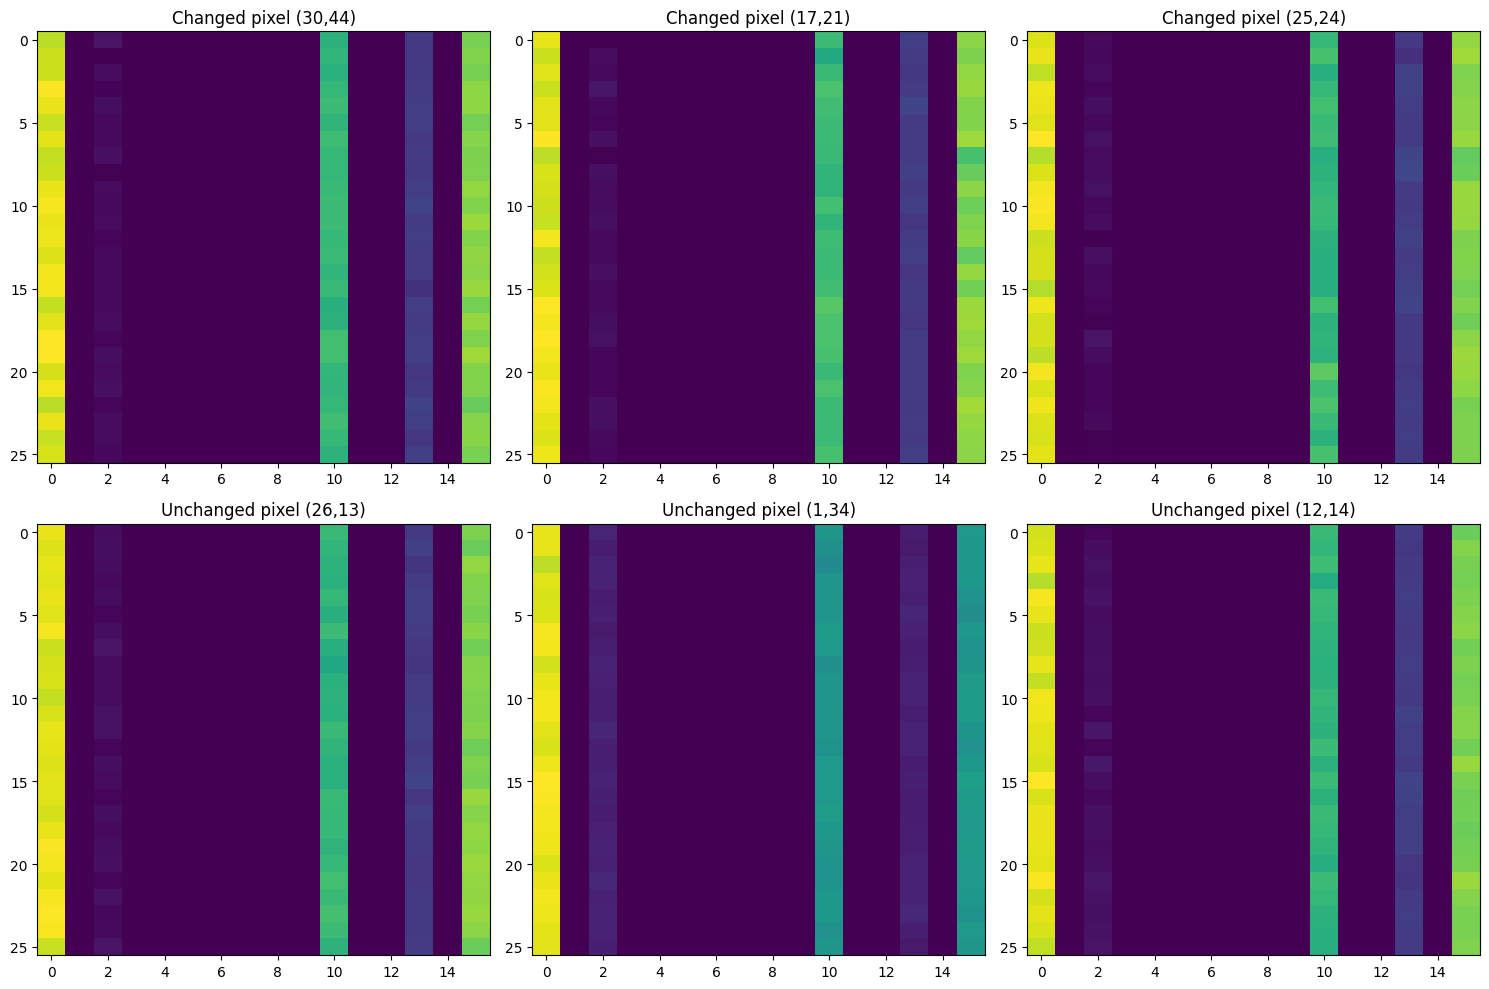

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

# Plot 3 changed pixels
for i, (y,x) in enumerate(changed_sel):
    seq = extract_pixel_seq(feature_maps, y, x)
    plt.subplot(2, 3, i+1)
    plt.imshow(seq.detach().numpy(), aspect='auto', cmap='viridis')
    plt.title(f"Changed pixel ({y},{x})")

# Plot 3 unchanged pixels
for i, (y,x) in enumerate(unchanged_sel):
    seq = extract_pixel_seq(feature_maps, y, x)
    plt.subplot(2, 3, i+4)
    plt.imshow(seq.detach().numpy(), aspect='auto', cmap='viridis')
    plt.title(f"Unchanged pixel ({y},{x})")

plt.tight_layout()
plt.show()

In [46]:
################# PIXEL-WISE LSTM??? CNN features at T timesteps → LSTM → probability of change ####
import torch
import torch.nn as nn

class PixelLSTM(nn.Module):
    def __init__(self, feature_dim=16, hidden_dim=32):
        """
        feature_dim = CNN output channels
        hidden_dim = LSTM hidden size
        """
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=feature_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim, 1)  # output: probability of deforestation

    def forward(self, pixel_sequences):
        """
        pixel_sequences: (N_pixels, T, feature_dim)
        returns: (N_pixels, 1)
        """
        lstm_out, _ = self.lstm(pixel_sequences)      # (N_pixels, T, hidden_dim)
        last_out = lstm_out[:, -1, :]                 # (N_pixels, hidden_dim)
        logits = self.fc(last_out)                    # (N_pixels, 1)
        return logits


In [47]:
pixel_lstm = PixelLSTM(feature_dim=16, hidden_dim=32)

# Fake sequence for 2304 pixels, 30 timesteps, 16 features
dummy_seq = torch.randn(2304, 30, 16)

out = pixel_lstm(dummy_seq)
print(out.shape)

torch.Size([2304, 1])


In [48]:
cnn = CNNFeatureExtractor(out_channels=16)
pixel_lstm = PixelLSTM(feature_dim=16, hidden_dim=32)

cnn.eval()
pixel_lstm.eval()

for i in range(len(train_dataset.indices)):
    idx = train_dataset.indices[i]
    sample_raw = read_sample(idx)
    if sample_raw['label'][1].sum() > 0:
        change_idx = idx
        break

sample_raw = read_sample(change_idx)
sample = normalize_sample(sample_raw)


img_valid, _ = get_valid_timesteps(sample)
T = img_valid.shape[0]
print("Valid timesteps:", T)


feature_maps = []
for t in range(T):
    x_t = img_valid[t].unsqueeze(0)   # (1,2,48,48)
    fm = cnn(x_t)[0]                  # (16,48,48)
    feature_maps.append(fm)


cnn_features = torch.stack(feature_maps)  # (T,16,48,48)


T, C, H, W = cnn_features.shape

pixel_seqs = cnn_features.permute(2,3,0,1).reshape(H*W, T, C)
# shape: (2304, T, 16)


pixel_logits = pixel_lstm(pixel_seqs)     # (2304,1)
pred_mask = pixel_logits.reshape(H, W)    # (48,48)
pred_mask_prob = torch.sigmoid(pred_mask) # convert logits → probabilities

Valid timesteps: 26


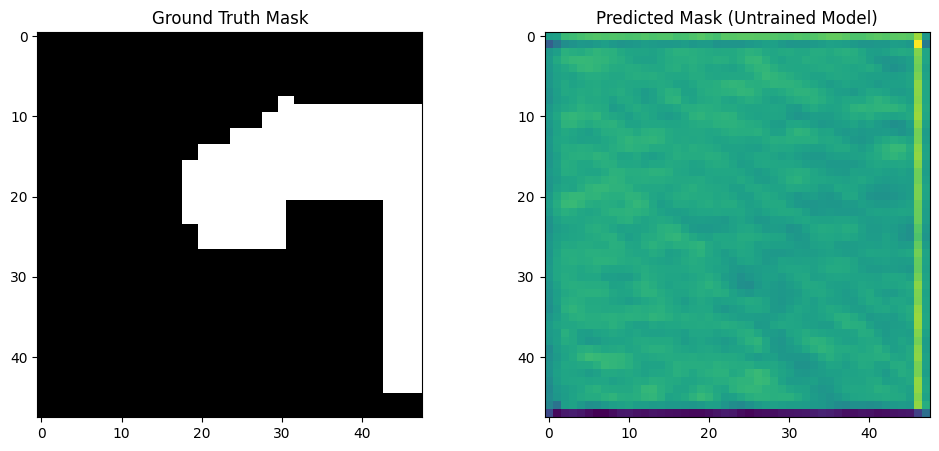

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(sample_raw['label'][1], cmap='gray')
plt.title("Ground Truth Mask")

plt.subplot(1,2,2)
plt.imshow(pred_mask_prob.detach().numpy(), cmap='viridis')
plt.title("Predicted Mask (Untrained Model)")

plt.show()


In [50]:
######################## TRYING TO PUT IT ALL TGT ###########################

In [26]:
import torch
import torch.nn as nn

class CNNFeatureExtractor(nn.Module):
    def __init__(self, out_channels=16):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        # x: (B, 2, 48, 48)
        return self.conv(x)   # (B, out_channels, 48, 48)


class PixelLSTM(nn.Module):
    def __init__(self, feature_dim=16, hidden_dim=32):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=feature_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, pixel_sequences):
        # pixel_sequences: (N_pixels, T, feature_dim)
        lstm_out, _ = self.lstm(pixel_sequences)   # (N_pixels, T, hidden_dim)
        last_out = lstm_out[:, -1, :]              # (N_pixels, hidden_dim)
        logits = self.fc(last_out)                 # (N_pixels, 1)
        return logits


In [27]:
class CNNLSTMDeforestation(nn.Module):
    def __init__(self, feature_dim=16, hidden_dim=32):
        super().__init__()
        self.cnn = CNNFeatureExtractor(out_channels=feature_dim)
        self.pixel_lstm = PixelLSTM(feature_dim=feature_dim,
                                    hidden_dim=hidden_dim)

    def forward(self, x):
        """
        x: (B, T, 2, 48, 48)
        returns logits: (B, 48, 48)
        NOTE: we assume B = 1 because of variable-length T
        """
        B, T, C, H, W = x.shape
        assert B == 1, "Use batch_size=1 for variable-length sequences."

        x = x[0]   # now (T, 2, 48, 48)

        # 1. CNN per timestep
        feature_maps = []
        for t in range(T):
            x_t = x[t].unsqueeze(0)          # (1,2,48,48)
            fm_t = self.cnn(x_t)[0]          # (feature_dim,48,48)
            feature_maps.append(fm_t)

        # 2. Stack over T → (T, F, H, W)
        cnn_features = torch.stack(feature_maps, dim=0)

        # 3. Rearrange to pixel sequences: (N_pixels, T, feature_dim)
        T, F, H, W = cnn_features.shape
        pixel_seqs = cnn_features.permute(2, 3, 0, 1).reshape(H*W, T, F)

        # 4. LSTM per pixel → (N_pixels, 1)
        pixel_logits = self.pixel_lstm(pixel_seqs)   # (H*W, 1)

        # 5. Reshape back to mask and add batch dim: (1, H, W)
        mask_logits = pixel_logits.view(H, W).unsqueeze(0)

        return mask_logits


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNLSTMDeforestation(feature_dim=16, hidden_dim=32).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [34]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0

    for batch in loader:
        # If your dataset returns 3 things (img, lbl, idx):
        if len(batch) == 3:
            imgs, lbls, _ = batch
        else:
            imgs, lbls = batch

        # imgs: (B, T, 2, 48, 48), lbls: (B, 48, 48)
        imgs = imgs.to(device).float()
        lbls = lbls.to(device).float()

        optimizer.zero_grad()

        logits = model(imgs)              # (B, 48, 48)
        loss = criterion(logits, lbls)    # BCEWithLogitsLoss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in loader:
            if len(batch) == 3:
                imgs, lbls, _ = batch
            else:
                imgs, lbls = batch

            imgs = imgs.to(device).float()
            lbls = lbls.to(device).float()

            logits = model(imgs)
            loss = criterion(logits, lbls)

            total_loss += loss.item()

    return total_loss / len(loader)

In [ ]:
num_epochs = 5  # start small

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss   = evaluate(model, val_loader, device)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1/5 | Train Loss: 0.4568 | Val Loss: 0.4649


In [ ]:
pos = 0
neg = 0
for i in range(len(train_dataset)):
    lbl = train_dataset[i][1]
    pos += (lbl == 1).sum().item()
    neg += (lbl == 0).sum().item()

print("Positive pixels:", pos)
print("Negative pixels:", neg)
print("Positive ratio:", pos / (pos+neg))

In [65]:
sample_imgs, sample_lbl, _ = next(iter(train_loader))

for i in range(50):
    optimizer.zero_grad()
    logits = model(sample_imgs)
    loss = criterion(logits, sample_lbl)
    loss.backward()
    optimizer.step()
    print(loss.item())

0.18407903611660004
0.18401020765304565
0.18356581032276154
0.1827840507030487
0.18170015513896942
0.18034619092941284
0.1787513941526413
0.17694184184074402
0.17494076490402222
0.17276853322982788
0.17044278979301453
0.16797827184200287
0.16538682579994202
0.16267725825309753
0.1598568856716156
0.156930074095726
0.15389959514141083
0.1507650911808014
0.14752241969108582
0.14416420459747314
0.14067943394184113
0.1370542198419571
0.13327254354953766
0.12931837141513824
0.1251785010099411
0.12084836512804031
0.11633924394845963
0.1116887629032135
0.10697081685066223
0.10229633003473282
0.09780807048082352
0.09353023022413254
0.08947566151618958
0.08559355139732361
0.0817902460694313
0.07803317904472351
0.07426963746547699
0.07050883769989014
0.06669804453849792
0.06284163147211075
0.05904386565089226
0.055473849177360535
0.05228172987699509
0.04935453087091446
0.04670068621635437
0.044239342212677
0.04194585978984833
0.039805829524993896
0.03782406821846962
0.035994067788124084
